In [19]:
import os
import sys
import cv2
import numpy as np
import time
from numba import cuda
import matplotlib.pyplot as plt

# Add the 'src' folder to the Python path
src_path = os.path.abspath(os.path.join("..", "src"))
sys.path.append(src_path)

# Now import the modules
from kernels.edge_detection import edge_detection, d_sobel_x, d_sobel_y
from kernels.histogram_equalization import histogram_equalization

In [8]:
# Function to process images
def process_image(input_image):
    output_image_hist_eq = np.zeros_like(input_image, dtype=np.uint8)
    output_image_edge = np.zeros_like(input_image, dtype=np.uint8)

    hist = np.zeros(256, dtype=np.int32)
    for value in input_image.ravel():
        hist[value] += 1

    cdf = hist.cumsum()
    cdf_min = cdf[np.nonzero(cdf)[0][0]]
    total_pixels = input_image.size

    d_input_image = cuda.to_device(input_image)
    d_output_hist_eq = cuda.to_device(output_image_hist_eq)
    d_output_edge = cuda.to_device(output_image_edge)

    threads_per_block = (16, 16)
    blocks_per_grid_x = (input_image.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (input_image.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    histogram_equalization[blocks_per_grid, threads_per_block](
        d_input_image, d_output_hist_eq, hist, cdf_min, total_pixels
    )
    edge_detection[blocks_per_grid, threads_per_block](
        d_input_image, d_output_edge, d_sobel_x, d_sobel_y
    )

    output_image_hist_eq = d_output_hist_eq.copy_to_host()
    output_image_edge = d_output_edge.copy_to_host()

    return output_image_hist_eq, output_image_edge

In [22]:
# Main processing function
def main(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for image_name in os.listdir(input_folder):
        input_path = os.path.join(input_folder, image_name)
        output_path_hist_eq = os.path.join(output_folder, f"hist_eq_{image_name}")
        output_path_edge = os.path.join(output_folder, f"edge_{image_name}")

        input_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if input_image is None:
            print(f"Skipping invalid image: {input_path}")
            continue

        print(f"Processing {image_name} with dimensions: {input_image.shape}")

        start_time = time.time()
        hist_eq_image, edge_image = process_image(input_image)
        processing_time = time.time() - start_time

        print(f"Processed {image_name} in {processing_time:.2f} seconds")

        cv2.imwrite(output_path_hist_eq, hist_eq_image)
        cv2.imwrite(output_path_edge, edge_image)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(input_image, cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title("Histogram Equalized")
        plt.imshow(hist_eq_image, cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title("Edge Detected")
        plt.imshow(edge_image, cmap="gray")

        plt.tight_layout()
        plt.show()

Processing input_image_l.jpg with dimensions: (2440, 3840)
Processed input_image_l.jpg in 3.40 seconds


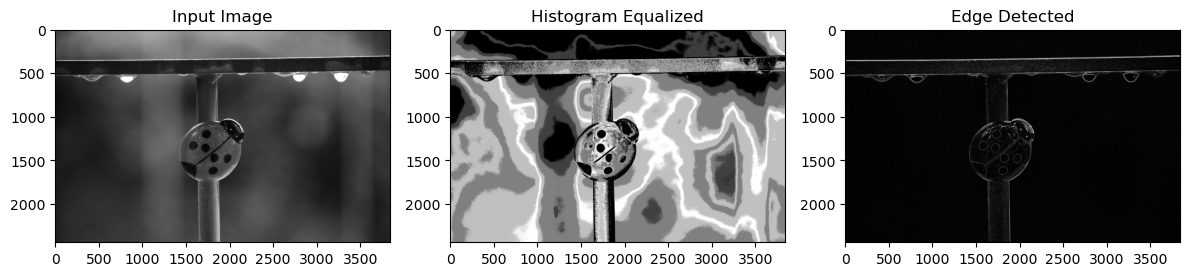

Processing Juvenile_Ragdoll.jpg with dimensions: (921, 1024)
Processed Juvenile_Ragdoll.jpg in 0.34 seconds


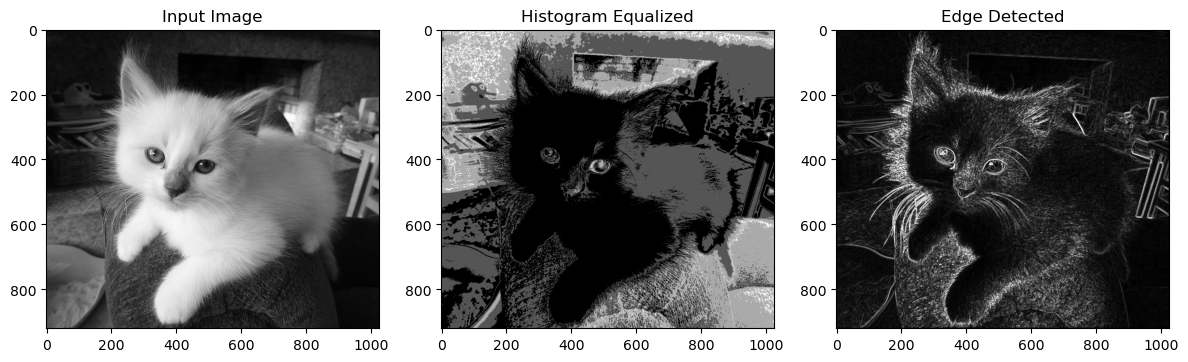

Processing Juvenile_Ragdoll_large.jpg with dimensions: (3000, 3336)
Processed Juvenile_Ragdoll_large.jpg in 4.31 seconds


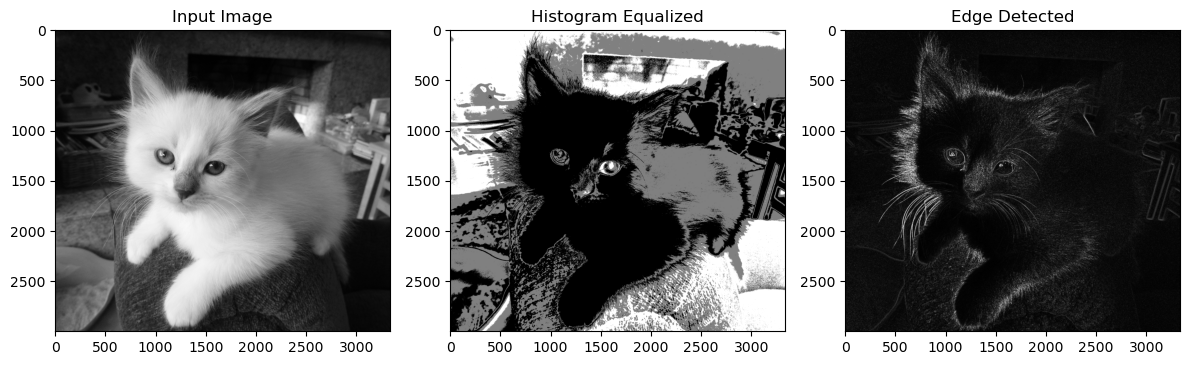

In [25]:
if __name__ == "__main__":
    input_folder = "data/input_images"
    output_folder = "data/output_images"
    main(input_folder, output_folder)